## Building a Model for Text Prediction (Generation)

- To build such a model we follow the general NLP pipeline while performing an additional step before training

**NLP Pipeline**  
1. Extraction of Training Data
2. Removal of Stopwords and Filteration of Punctuations

*`Exception`*: Incase of text generation stopword filteration may be ignored to generate meaningful sentences

3. Tokenization
4. Transformation from Sentences to Sequences
5. Encoding Sequences with Embeddings

*`New Step`*: Converting the Sequences to Input Sequences with their corresponding labels
- This step is vital to build models which can predict the next words in a sentence.
- Given any input sequence with missing values: *`Seed`*
- The model utilises the context and embeddings to predict the next **Label**
- Looping over this process, we can create a model that can generate large sentences
- This process is Similar to **`N - Gram Models`**

6. Model Training on different Input Sequences
7. Performance Evaluation and Optimization
8. Generating new sentences given a seed (Input Sentence)

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

2024-02-19 18:10:20.491955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 18:10:20.492101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 18:10:20.638108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Converting Training Sequences into Input Sequences

In [2]:
text = """In the town of Athy one Jeremy Lanigan \n
Battered away til he hadnt a pound. \n
His father died and made him a man again \n
Left him a farm and ten acres of ground. \n
He gave a grand party for friends and relations \n
Who didnt forget him when come to the wall, \n
And if youll but listen Ill make your eyes glisten \n
Of the rows and the ructions of Lanigans Ball. \n
Myself to be sure got free invitation, \n
For all the nice girls and boys I might ask, \n
And just in a minute both friends and relations \n
Were dancing round merry as bees round a cask. \n
Judy ODaly, that nice little milliner, \n
She tipped me a wink for to give her a call, \n
And I soon arrived with Peggy McGilligan \n
Just in time for Lanigans Ball. \n
There were lashings of punch and wine for the ladies, \n
Potatoes and cakes; there was bacon and tea, \n
There were the Nolans, Dolans, OGradys \n
Courting the girls and dancing away. \n
Songs they went round as plenty as water, \n
The harp that once sounded in Taras old hall,\n
Sweet Nelly Gray and The Rat Catchers Daughter,\n
All singing together at Lanigans Ball. \n
They were doing all kinds of nonsensical polkas \n
All round the room in a whirligig. \n
Julia and I, we banished their nonsense \n
And tipped them the twist of a reel and a jig. \n
Ach mavrone, how the girls got all mad at me \n
Danced til youd think the ceiling would fall. \n
For I spent three weeks at Brooks Academy \n
Learning new steps for Lanigans Ball. \n
Three long weeks I spent up in Dublin, \n
Three long weeks to learn nothing at all,\n
Three long weeks I spent up in Dublin, \n
Learning new steps for Lanigans Ball. \n
She stepped out and I stepped in again, \n
I stepped out and she stepped in again, \n
She stepped out and I stepped in again, \n
Learning new steps for Lanigans Ball. \n
Boys were all merry and the girls they were hearty \n
And danced all around in couples and groups, \n
Til an accident happened, young Terrance McCarthy \n
Put his right leg through miss Finnertys hoops. \n
Poor creature fainted and cried Meelia murther, \n
Called for her brothers and gathered them all. \n
Carmody swore that hed go no further \n
Til he had satisfaction at Lanigans Ball. \n
In the midst of the row miss Kerrigan fainted, \n
Her cheeks at the same time as red as a rose. \n
Some of the lads declared she was painted, \n
She took a small drop too much, I suppose. \n
Her sweetheart, Ned Morgan, so powerful and able, \n
When he saw his fair colleen stretched out by the wall, \n
Tore the left leg from under the table \n
And smashed all the Chaneys at Lanigans Ball. \n
Boys, oh boys, twas then there were runctions. \n
Myself got a lick from big Phelim McHugh. \n
I soon replied to his introduction \n
And kicked up a terrible hullabaloo. \n
Old Casey, the piper, was near being strangled. \n
They squeezed up his pipes, bellows, chanters and all. \n
The girls, in their ribbons, they got all entangled \n
And that put an end to Lanigans Ball."""

**Tokenizing the Text**

In [3]:
tokenizer = Tokenizer()

# Splitting the Text into Sentences
corpus = text.lower().split("\n")
print("Few Sentences from the Corpus:\n")
for i in corpus[:5]:
    print(i)
    
# Tokenization
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
print("\nTotal no of words learnt: ", len(word_index) + 1)

print("Most frequently occurring words:\n")
for i in list(word_index.items())[:5]:
    print(i)
    
# Converting the Sentences into Sequences
sequences = tokenizer.texts_to_sequences(corpus)
print("\nInput Sentences as Sequences:\n")
for i in sequences[1:6]:
    print(i)

Few Sentences from the Corpus:

in the town of athy one jeremy lanigan 

battered away til he hadnt a pound. 

his father died and made him a man again 

Total no of words learnt:  263
Most frequently occurring words:

('and', 1)
('the', 2)
('a', 3)
('in', 4)
('all', 5)

Input Sentences as Sequences:

[]
[71, 40, 20, 21, 72, 3, 73]
[]
[16, 74, 75, 1, 76, 33, 3, 77, 22]
[]


**Converting the Sequences into Input Sequences**

In [4]:
# A list of all the n-gram input sequences
input_seq = []

# Iterating over the Sequences to generate the Input Sequences
for seq in sequences:
    for i in range(1, len(seq)):
        n_gram_input_seq = seq[:i + 1]
        input_seq.append(n_gram_input_seq)
        
print("Viewing the first 10 input sequences:\n")
for i in input_seq[:10]:
    print(i)
    
print("\nTotal No of Input Sequences: ", len(input_seq))

Viewing the first 10 input sequences:

[4, 2]
[4, 2, 66]
[4, 2, 66, 8]
[4, 2, 66, 8, 67]
[4, 2, 66, 8, 67, 68]
[4, 2, 66, 8, 67, 68, 69]
[4, 2, 66, 8, 67, 68, 69, 70]
[71, 40]
[71, 40, 20]
[71, 40, 20, 21]

Total No of Input Sequences:  453


**Applying Padding to Unify the Input Size**

In [5]:
# Calculating the Max Length based on the sizes of all the sentences
maxlen = max([len(i) for i in input_seq])

# Applying padding and converting the seq to an array
padded_input_seq = np.array(pad_sequences(input_seq, maxlen=maxlen))

print("First 10 Padded Sequences:\n")
for i in padded_input_seq[:10]:
    print(i)
    
print("\nThe maximum length of the sentence is: ", maxlen)

First 10 Padded Sequences:

[0 0 0 0 0 0 0 0 0 4 2]
[ 0  0  0  0  0  0  0  0  4  2 66]
[ 0  0  0  0  0  0  0  4  2 66  8]
[ 0  0  0  0  0  0  4  2 66  8 67]
[ 0  0  0  0  0  4  2 66  8 67 68]
[ 0  0  0  0  4  2 66  8 67 68 69]
[ 0  0  0  4  2 66  8 67 68 69 70]
[ 0  0  0  0  0  0  0  0  0 71 40]
[ 0  0  0  0  0  0  0  0 71 40 20]
[ 0  0  0  0  0  0  0 71 40 20 21]

The maximum length of the sentence is:  11


## Splitting the Input Sequences into Features and Labels

**Eg:**

[ 0  0  0  0  0  0  0  0  5  3 17]  
Here:
- **Input Features** : `[ 0  0  0  0  0  0  0  0  5  3`
- **Label** : `17]`

In [6]:
input_features, labels = padded_input_seq[:, :-1], padded_input_seq[:, -1]

print("Viewing the first 5 Features and the Corresponding Labels:\n")
for i in range(5):
    print("Input Feature: ", input_features[i], "\nLabel: ", labels[i], 
          "\nOriginal Input Sequence: ", padded_input_seq[i], end="\n\n")

Viewing the first 5 Features and the Corresponding Labels:

Input Feature:  [0 0 0 0 0 0 0 0 0 4] 
Label:  2 
Original Input Sequence:  [0 0 0 0 0 0 0 0 0 4 2]

Input Feature:  [0 0 0 0 0 0 0 0 4 2] 
Label:  66 
Original Input Sequence:  [ 0  0  0  0  0  0  0  0  4  2 66]

Input Feature:  [ 0  0  0  0  0  0  0  4  2 66] 
Label:  8 
Original Input Sequence:  [ 0  0  0  0  0  0  0  4  2 66  8]

Input Feature:  [ 0  0  0  0  0  0  4  2 66  8] 
Label:  67 
Original Input Sequence:  [ 0  0  0  0  0  0  4  2 66  8 67]

Input Feature:  [ 0  0  0  0  0  4  2 66  8 67] 
Label:  68 
Original Input Sequence:  [ 0  0  0  0  0  4  2 66  8 67 68]



## Encoding the Labels

- Encoding of labels is done for the model to better map the input with the output.
- One hot encoding is done to place the word in accordance to the entire plausible set of output word classes

In [7]:
encoded_labels = tf.keras.utils.to_categorical(
    labels, num_classes=len(word_index) + 1
)

ex_idx = 5
print("Viewing the Input and Output for an example:\n")
print("Original Sentence: ", padded_input_seq[ex_idx])
print("Input Feature: ", input_features[ex_idx])
print("Label: ", labels[ex_idx])
print("Encoded Label:\n", encoded_labels[ex_idx])

Viewing the Input and Output for an example:

Original Sentence:  [ 0  0  0  0  4  2 66  8 67 68 69]
Input Feature:  [ 0  0  0  0  4  2 66  8 67 68]
Label:  69
Encoded Label:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Creating the Model

In [8]:
tf.keras.backend.clear_session()

In [9]:
# Using Callback to Automatically Stop training and restore Best Weights
earlystop_cb = EarlyStopping(monitor="loss", patience=15, restore_best_weights=True)

In [10]:
total_no_of_word = len(word_index) + 1

model = Sequential([
    
    # Lesser Embedding dimensions due to lesser words
    Embedding(total_no_of_word, 8),
    
    # Maxlen used to create LSTM's inline with maximum number of timesteps
    Bidirectional(LSTM(maxlen - 1)),
    
    ## Hidden layers
    Dense(maxlen, activation="relu"),
    Dense(total_no_of_word, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           2104      
                                                                 
 bidirectional (Bidirection  (None, 20)                1520      
 al)                                                             
                                                                 
 dense (Dense)               (None, 11)                231       
                                                                 
 dense_1 (Dense)             (None, 263)               3156      
                                                                 
Total params: 7011 (27.39 KB)
Trainable params: 7011 (27.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer="adam"
)

In [12]:
history = model.fit(
    input_features, encoded_labels, epochs=1500, verbose=1, callbacks=[earlystop_cb]
)

Epoch 1/1500


I0000 00:00:1708366239.119387      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 7s 136ms/step - loss: 5.5700 - accuracy: 0.0353
Epoch 2/1500
15/15 [==============================] - 1s 86ms/step - loss: 5.5597 - accuracy: 0.0486
Epoch 3/1500
15/15 [==============================] - 1s 75ms/step - loss: 5.5440 - accuracy: 0.0486
Epoch 4/1500
15/15 [==============================] - 1s 73ms/step - loss: 5.5085 - accuracy: 0.0486
Epoch 5/1500
15/15 [==============================] - 1s 52ms/step - loss: 5.4255 - accuracy: 0.0486
Epoch 6/1500
15/15 [==============================] - 1s 40ms/step - loss: 5.2616 - accuracy: 0.0486
Epoch 7/1500
15/15 [==============================] - 0s 18ms/step - loss: 5.1518 - accuracy: 0.0486
Epoch 8/1500
15/15 [==============================] - 0s 6ms/step - loss: 5.1035 - accuracy: 0.0486
Epoch 9/1500
15/15 [==============================] - 0s 29ms/step - loss: 5.0784 - accuracy: 0.0486
Epoch 10/1500
15/15 [==============================] - 0s 18ms/step - loss: 5.0604 - accuracy: 0.0508
Ep

In [13]:
def plot_model(history, metric=""):
    plt.title(metric.capitalize() + " Performance")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.plot(history.history[metric])
    plt.show()

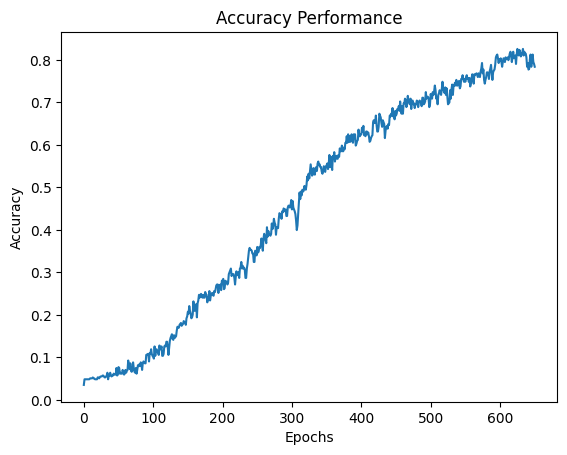

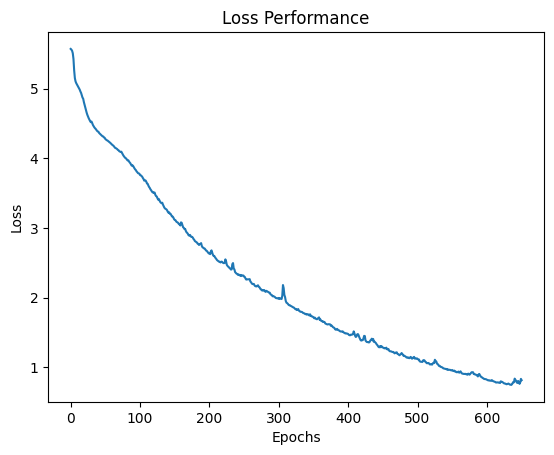

In [14]:
plot_model(history, "accuracy")
plot_model(history, "loss")

**Inference**
- We can see that the model has achieved an accuracy of over 95% without earlystopping while keeping minimal loss
- Thus there is no overfitting and we can assume the model to predict the next word given a context (which it was trained on / similar) correctly 95% of the time

## Generating the Next Word

In [15]:
word_idx_reverse = OrderedDict(sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True))
word_idx_reverse = list(word_idx_reverse.items())

In [16]:
# Providing the Intial Context with the Seed Text
seed_text = "in a town of athy"

# Tokenization and Sequencing
seed_seq = tokenizer.texts_to_sequences([seed_text])

# Padding
pad_seed = pad_sequences(seed_seq, maxlen=maxlen - 1)

# Making the prediction
prediction = np.argmax(model.predict(pad_seed))
print("Word Index of the Prediction: ", prediction)
print("Word Predicted: ", word_idx_reverse[prediction - 1][0])
print("Original Sentence: ", corpus[0])

1/1 [==============================] - 1s 694ms/step
Word Index of the Prediction:  55
Word Predicted:  old
Original Sentence:  in the town of athy one jeremy lanigan 


**Inference**
- Yay 🙌 thus for this case the model has made the correct prediction for the given seed considering the learnt context
- Although generating entire sentences is a whole different 🥎 game 😭

## Generating Text

In [17]:
seed_text = "And if youll but listen Ill make".lower()
next_words = 10
corpus_idx = 12

for i in range(next_words):
    
    # Tokenization and Padding
    seq_of_tokens = tokenizer.texts_to_sequences([seed_text])
    seq_of_tokens_padded = pad_sequences(seq_of_tokens, maxlen=maxlen - 1)
    
    # Prediction and Reverse Indexing to find the word
    predicted = np.argmax(model.predict(seq_of_tokens_padded, verbose=0))
    out_word = word_idx_reverse[predicted - 1][0]
    
    # Updating the Seed Text to continue generation
    seed_text += " " + out_word
    
print("The AI generated text is:")
print(seed_text)

print("\nOriginal text is:")
print(corpus[corpus_idx : corpus_idx + 4])

The AI generated text is:
and if youll but listen ill make your eyes glisten glisten one one invitation invitation colleen listen

Original text is:
['and if youll but listen ill make your eyes glisten ', '', 'of the rows and the ructions of lanigans ball. ', '']


**Inference**
- While the model makes its initial predictions correctly, overtime it generates meaningless sentences
- This is due to change in window-size and context while making the predictions
- The Input Sequences (Training Set) we used had a window size of 1 and was limited to the "EOF" / "\n" delimiter for each of the sentences
- Thus making one bad prediction reduced the overall likelihood of making better predictions in the later half of the sentence

## Extending the Dataset

In [18]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2024-02-19 18:12:05--  https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.207, 74.125.141.207, 142.251.162.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: '/tmp/irish-lyrics-eof.txt'

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2024-02-19 18:12:06 (63.0 MB/s) - '/tmp/irish-lyrics-eof.txt' saved [68970/68970]



## Reiterating the NLP Pipeline for the Extended Dataset

In [19]:
with open("/tmp/irish-lyrics-eof.txt", "r") as text_file:
    lines = text_file.read().lower().split("\n")
    
print("Viewing the first 5 lines:\n")
for i in lines[:5]:
    print(i)

Viewing the first 5 lines:

come all ye maidens young and fair
and you that are blooming in your prime
always beware and keep your garden fair
let no man steal away your thyme
for thyme it is a precious thing


In [20]:
# Tokenization
new_tokenizer = Tokenizer()
new_tokenizer.fit_on_texts(lines)

# Converting the Text to Sequences
sequences = new_tokenizer.texts_to_sequences(lines)
print("Total no of sequences: ", len(sequences))

# Creating Input Sequences
new_input_sequences = []
for seq in sequences:
    for i in range(1, len(seq)):
        n_gram_seq = seq[:i + 1]
        new_input_sequences.append(n_gram_seq)
        
print("\nTotal no of Input Sequences: ", len(new_input_sequences))

# Applying Padding
maxlen = max([len(i) for i in new_input_sequences])
padded_new_input_sequences = pad_sequences(new_input_sequences, maxlen=maxlen)
print("\nMaximum length of sentence in Input Sequences: ", maxlen)

print("\nViewing the Padded Input Sequences:\n")
for i in padded_new_input_sequences[:10]:
    print(i)

Total no of sequences:  1693

Total no of Input Sequences:  12038

Maximum length of sentence in Input Sequences:  16

Viewing the Padded Input Sequences:

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 51 12]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 51 12 96]
[   0    0    0    0    0    0    0    0    0    0    0    0   51   12
   96 1217]
[   0    0    0    0    0    0    0    0    0    0    0   51   12   96
 1217   48]
[   0    0    0    0    0    0    0    0    0    0   51   12   96 1217
   48    2]
[   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2   69]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2 11]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  2 11 15]
[ 0  0  0  0  0  0  0  0  0  0  0  0  2 11 15 31]
[  0   0   0   0   0   0   0   0   0   0   0   2  11  15  31 361]


In [21]:
# Splitting the Features and the Labels
xs, labels = padded_new_input_sequences[:, :-1], padded_new_input_sequences[:, -1]

word_index = new_tokenizer.word_index
total_words = len(word_index) + 1
print("Total no of words: ", total_words)

# Encoding the Labels
ys = tf.keras.utils.to_categorical(
    labels, num_classes=total_words
)

print("\nViewing an Example with all the values:\n")
print("Original String:\n", lines[0])
print("\nPadded and Encoded String - Input Feature:\n", xs[0])
print("\nLabel:\n", labels[0])
print("\nEncoded Label - Label:\n", ys[0])

Total no of words:  2690

Viewing an Example with all the values:

Original String:
 come all ye maidens young and fair

Padded and Encoded String - Input Feature:
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 51]

Label:
 12

Encoded Label - Label:
 [0. 0. 0. ... 0. 0. 0.]


## Building the Same Model

In [22]:
tf.keras.backend.clear_session()

In [23]:
same_model = Sequential([    
    # NLP Specific Layers
    Embedding(total_words, 10),
    Bidirectional(LSTM(maxlen)),
    
    # Hidden Layers
    Dense(25, activation="relu"),
    Dense(total_words, activation="softmax")
])

same_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          26900     
                                                                 
 bidirectional (Bidirection  (None, 32)                3456      
 al)                                                             
                                                                 
 dense (Dense)               (None, 25)                825       
                                                                 
 dense_1 (Dense)             (None, 2690)              69940     
                                                                 
Total params: 101121 (395.00 KB)
Trainable params: 101121 (395.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
same_model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=Adam(learning_rate=5e-3)
)

In [25]:
history = same_model.fit(
    xs, ys, epochs=500, verbose=2, callbacks=[earlystop_cb]
)

Epoch 1/500
377/377 - 14s - loss: 6.7374 - accuracy: 0.0655 - 14s/epoch - 38ms/step
Epoch 2/500
377/377 - 3s - loss: 6.2820 - accuracy: 0.0658 - 3s/epoch - 8ms/step
Epoch 3/500
377/377 - 3s - loss: 6.1299 - accuracy: 0.0752 - 3s/epoch - 8ms/step
Epoch 4/500
377/377 - 3s - loss: 5.9650 - accuracy: 0.0879 - 3s/epoch - 7ms/step
Epoch 5/500
377/377 - 3s - loss: 5.7959 - accuracy: 0.0964 - 3s/epoch - 7ms/step
Epoch 6/500
377/377 - 3s - loss: 5.6440 - accuracy: 0.1043 - 3s/epoch - 7ms/step
Epoch 7/500
377/377 - 2s - loss: 5.5152 - accuracy: 0.1144 - 2s/epoch - 6ms/step
Epoch 8/500
377/377 - 3s - loss: 5.4077 - accuracy: 0.1228 - 3s/epoch - 7ms/step
Epoch 9/500
377/377 - 3s - loss: 5.3001 - accuracy: 0.1289 - 3s/epoch - 7ms/step
Epoch 10/500
377/377 - 3s - loss: 5.2020 - accuracy: 0.1337 - 3s/epoch - 7ms/step
Epoch 11/500
377/377 - 3s - loss: 5.1083 - accuracy: 0.1367 - 3s/epoch - 7ms/step
Epoch 12/500
377/377 - 2s - loss: 5.0206 - accuracy: 0.1445 - 2s/epoch - 6ms/step
Epoch 13/500
377/377 -

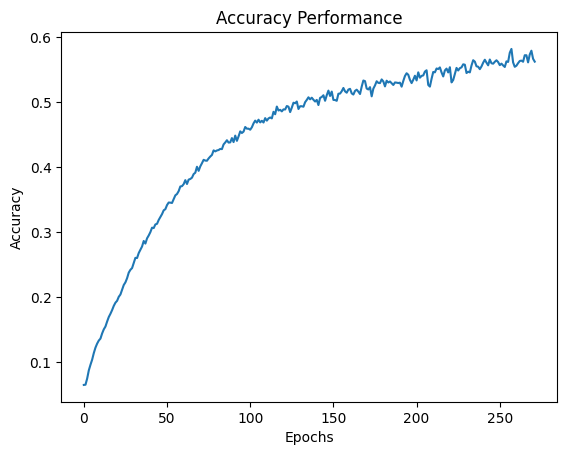

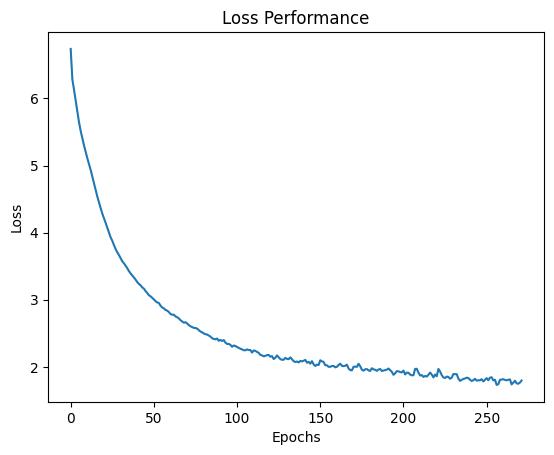

In [26]:
plot_model(history, "accuracy")
plot_model(history, "loss")

**Inference**
- We can see that the model is slowly converging without earlystopping
- There is still scope for improving the data and input sequences to reduce the loss

## Generating Text with Extended Data

In [27]:
# Checking the Word Index variable
list(word_index.items())[:5]

[('the', 1), ('and', 2), ('i', 3), ('to', 4), ('a', 5)]

In [28]:
word_idx_reverse = OrderedDict(sorted(word_index.items(), key=lambda x: x[1], reverse=True))
word_idx_reverse = list(word_idx_reverse.items())

In [29]:
# Checking the Reverse Index variable
word_idx_reverse[:5]

[('yon', 2689),
 ('pluck', 2688),
 ('summertime', 2687),
 ('maids', 2686),
 ('bollin', 2685)]

**Making Predictions with the Same Model on the Extended Dataset**

In [30]:
seed_text = "and if youll but listen ill make"
next_words = 10

for i in range(next_words):
    
    # Tokenization and Padding
    seq_of_tokens = new_tokenizer.texts_to_sequences([seed_text])
    seq_of_tokens_padded = pad_sequences(seq_of_tokens, maxlen=maxlen - 1)
    
    # Prediction and Reverse Indexing to find the word
    predicted = np.argmax(same_model.predict(seq_of_tokens_padded, verbose=0))
    out_word = word_idx_reverse[predicted - 1][0]
    
    # Updating the Seed Text to continue generation
    seed_text += " " + out_word
    
print("The AI generated text is:")
print(seed_text)

print("\nOriginal text is:")
print('and if youll but listen ill make your eyes glisten of the rows and the ructions of lanigans ball.')

The AI generated text is:
and if youll but listen ill make bollin glance couldnt jailer draw yon returning charges bacchus elf

Original text is:
and if youll but listen ill make your eyes glisten of the rows and the ructions of lanigans ball.


## Changing the Model Architecture

In [31]:
tf.keras.backend.clear_session()

In [32]:
new_model = Sequential([
    Embedding(total_words, 16),
    Bidirectional(LSTM(maxlen - 1, return_sequences=True)),
    Bidirectional(LSTM(maxlen - 1)),
    Dense(total_words, activation="softmax")
])

new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          43040     
                                                                 
 bidirectional (Bidirection  (None, None, 30)          3840      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 30)                5520      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 2690)              83390     
                                                                 
Total params: 135790 (530.43 KB)
Trainable params: 135790 (530.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
new_model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=Adam(learning_rate=6e-3)
)

**Checking the Variables**

In [34]:
print("Input Feature:\n", xs[5])
print("\nLabel:\n", np.argmax(ys[5]))
print("\nEncoded Training Example:\n", padded_new_input_sequences[5])
print("\nOriginal Line:\n", lines[0])

Input Feature:
 [   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]

Label:
 69

Encoded Training Example:
 [   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2   69]

Original Line:
 come all ye maidens young and fair


In [35]:
history = new_model.fit(
    xs, ys, epochs=500, verbose=2, callbacks=[earlystop_cb]
)

Epoch 1/500
377/377 - 18s - loss: 6.7328 - accuracy: 0.0651 - 18s/epoch - 47ms/step
Epoch 2/500
377/377 - 4s - loss: 6.2313 - accuracy: 0.0749 - 4s/epoch - 12ms/step
Epoch 3/500
377/377 - 4s - loss: 5.9910 - accuracy: 0.0897 - 4s/epoch - 10ms/step
Epoch 4/500
377/377 - 4s - loss: 5.8211 - accuracy: 0.0992 - 4s/epoch - 10ms/step
Epoch 5/500
377/377 - 3s - loss: 5.6879 - accuracy: 0.1050 - 3s/epoch - 9ms/step
Epoch 6/500
377/377 - 4s - loss: 5.5730 - accuracy: 0.1137 - 4s/epoch - 10ms/step
Epoch 7/500
377/377 - 4s - loss: 5.4681 - accuracy: 0.1203 - 4s/epoch - 10ms/step
Epoch 8/500
377/377 - 3s - loss: 5.3706 - accuracy: 0.1266 - 3s/epoch - 9ms/step
Epoch 9/500
377/377 - 3s - loss: 5.2697 - accuracy: 0.1299 - 3s/epoch - 9ms/step
Epoch 10/500
377/377 - 3s - loss: 5.1731 - accuracy: 0.1361 - 3s/epoch - 9ms/step
Epoch 11/500
377/377 - 4s - loss: 5.0803 - accuracy: 0.1423 - 4s/epoch - 10ms/step
Epoch 12/500
377/377 - 4s - loss: 4.9913 - accuracy: 0.1495 - 4s/epoch - 9ms/step
Epoch 13/500
377

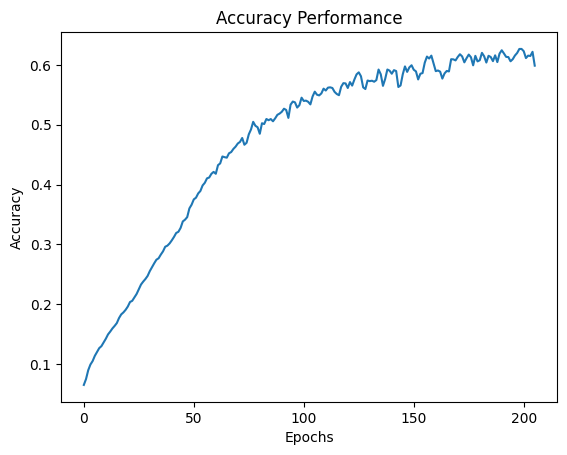

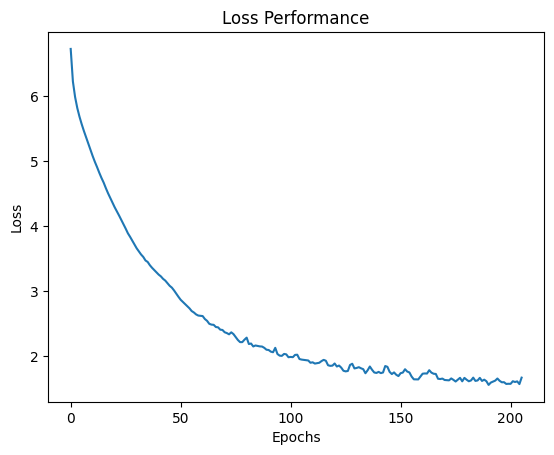

In [36]:
plot_model(history, "accuracy")
plot_model(history, "loss")

## Generating text with the Changed Model Architecture

In [37]:
seed_text = "and if youll but listen ill make".lower()
next_words = 10

for i in range(10):
    
    # Tokenization and Sequencing
    seq_of_tokens = new_tokenizer.texts_to_sequences([seed_text])
    padded_seq_of_token = pad_sequences(seq_of_tokens, maxlen=maxlen - 1)
    
    # Making the Prediction for the Seed Text
    prediction = np.argmax(new_model.predict(padded_seq_of_token, verbose=0))
    out_word = word_idx_reverse[prediction - 1][0]
    
    # Updating the Seed Text to continue text generation
    seed_text += " " + out_word
    
print("AI Generated Text:\n", seed_text)
print("\nOriginal Text:\nand if youll but listen ill make your eyes glisten of the rows and the ructions of lanigans ball.")

AI Generated Text:
 and if youll but listen ill make ready wheat william tailor mingling bollin hare pluck rust swear

Original Text:
and if youll but listen ill make your eyes glisten of the rows and the ructions of lanigans ball.


## Improving the Data

**Windowing 🪟**
- The process of consuming all the data at once while seeing only a part of the data at a time.
- This way we can create many more examples for the model to train on while gaining more context transcending multiple lines while making predictions for the next word.
- With better predictions for the next words we can generate better sentences.

$$ no \; of \; training \; examples \; after \; windowing = ((number \; of \; words - window \; size) * window \; size) $$

In [38]:
# Instead of splitting the sentences while loading we create sentences on the fly using windowing
window_size = 10
sentences = []
all_text = []

with open("/tmp/irish-lyrics-eof.txt", "r") as text_file:
    whole_lyrics = text_file.read().lower()
    all_text.append(whole_lyrics)
    
print("Total No of Words read: ", len(whole_lyrics))
words = whole_lyrics.split()
last_range = len(words) - maxlen

# Windowing to Create Sentences
for i in range(last_range):
    
    # New String to store the Windowed Sentence
    this_sentence = ""
    for window_off in range(0, window_size - 1):
        word = words[i + window_off]
        this_sentence += word + " "
        
    sentences.append(this_sentence)

print("\nTotal no of Sentences created using Windowing: ", len(sentences))

Total No of Words read:  68953

Total no of Sentences created using Windowing:  13652


**Applying the NLP Pipeline**

In [39]:
# Tokenization and Sequencing
final_tokenizer = Tokenizer()
final_tokenizer.fit_on_texts(all_text)
final_sequences = final_tokenizer.texts_to_sequences(sentences)

# Tracking the Length for Model Design and Predictions
total_words = len(final_tokenizer.word_index) + 1
print("Total No of Unique Words in the Corpus: ", total_words)

# Input Sequence Generation
final_input_sequences = []
for seq in final_sequences:
    for i in range(1, len(seq)):
        final_n_gram_input_seq = seq[:i + 1]
        final_input_sequences.append(final_n_gram_input_seq)
        
print("\nViewing the First 10 N-Gram input sequences:\n")
for i in final_input_sequences[:10]:
    print(i)
    
print("\nTotal no of Input Sequences created: ", len(final_input_sequences))

# Applying Padding
maxlen = max([len(seq) for seq in final_input_sequences])
print("\nMaximum Length of Input Sequence: ", maxlen)

padded_final_input_sequences = pad_sequences(final_input_sequences, maxlen=maxlen)
print("\nViewing the First 10 N-Gram padded input sequences:\n")
for i in padded_final_input_sequences[:10]:
    print(i)

Total No of Unique Words in the Corpus:  2690

Viewing the First 10 N-Gram input sequences:

[51, 12]
[51, 12, 96]
[51, 12, 96, 1217]
[51, 12, 96, 1217, 48]
[51, 12, 96, 1217, 48, 2]
[51, 12, 96, 1217, 48, 2, 69]
[51, 12, 96, 1217, 48, 2, 69, 2]
[51, 12, 96, 1217, 48, 2, 69, 2, 11]
[12, 96]
[12, 96, 1217]

Total no of Input Sequences created:  109774

Maximum Length of Input Sequence:  28

Viewing the First 10 N-Gram padded input sequences:

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 51 12]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 51 12 96]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   51   12   96 1217]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   51   12   96 1217   48]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   

In [40]:
# Splitting the Features and Labels
final_xs, final_labels = padded_final_input_sequences[:, :-1], padded_final_input_sequences[:, -1]

# Encoding the Labels
final_ys = tf.keras.utils.to_categorical(final_labels, num_classes=total_words)

print("Viewing all the Data Together:\n")
print("Original Text:\n", sentences[0])
print("\nInput Feature:\n", final_xs[6])
print("\nTarget Label:\n", np.argmax(final_ys[6]))
print("\nInput Sequence:\n", final_input_sequences[6])


Viewing all the Data Together:

Original Text:
 come all ye maidens young and fair and you 

Input Feature:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   51   12   96 1217   48    2   69]

Target Label:
 2

Input Sequence:
 [51, 12, 96, 1217, 48, 2, 69, 2]


## Building the Final Model

In [41]:
tf.keras.backend.clear_session()

In [42]:
final_model = Sequential([
    Embedding(total_words, 16, input_length=maxlen - 1),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(total_words, activation="softmax")
])

final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 16)            43040     
                                                                 
 bidirectional (Bidirection  (None, 27, 64)            12544     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 2690)              174850    
                                                                 
Total params: 255266 (997.13 KB)
Trainable params: 255266 (997.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
final_model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=Adam(6e-3)
)

In [44]:
history = final_model.fit(
    final_xs, final_ys, epochs=100, verbose=2, callbacks=[earlystop_cb]
)

Epoch 1/100
3431/3431 - 46s - loss: 5.7702 - accuracy: 0.1033 - 46s/epoch - 13ms/step
Epoch 2/100
3431/3431 - 34s - loss: 4.8705 - accuracy: 0.1543 - 34s/epoch - 10ms/step
Epoch 3/100
3431/3431 - 34s - loss: 4.2051 - accuracy: 0.2075 - 34s/epoch - 10ms/step
Epoch 4/100
3431/3431 - 34s - loss: 3.6736 - accuracy: 0.2625 - 34s/epoch - 10ms/step
Epoch 5/100
3431/3431 - 34s - loss: 3.2417 - accuracy: 0.3181 - 34s/epoch - 10ms/step
Epoch 6/100
3431/3431 - 34s - loss: 2.9075 - accuracy: 0.3703 - 34s/epoch - 10ms/step
Epoch 7/100
3431/3431 - 34s - loss: 2.6626 - accuracy: 0.4088 - 34s/epoch - 10ms/step
Epoch 8/100
3431/3431 - 34s - loss: 2.4586 - accuracy: 0.4462 - 34s/epoch - 10ms/step
Epoch 9/100
3431/3431 - 34s - loss: 2.2967 - accuracy: 0.4758 - 34s/epoch - 10ms/step
Epoch 10/100
3431/3431 - 34s - loss: 2.1665 - accuracy: 0.5016 - 34s/epoch - 10ms/step
Epoch 11/100
3431/3431 - 34s - loss: 2.0586 - accuracy: 0.5224 - 34s/epoch - 10ms/step
Epoch 12/100
3431/3431 - 33s - loss: 1.9736 - accura

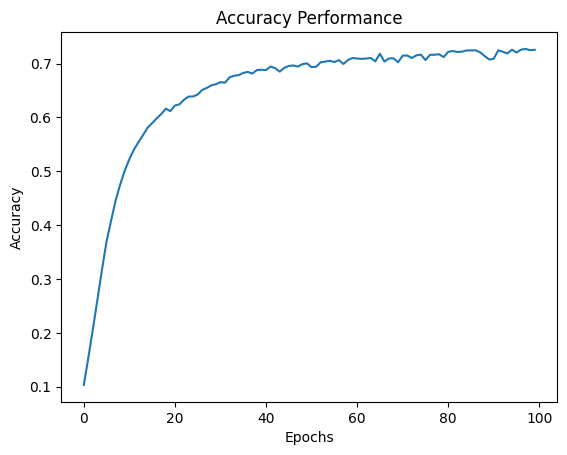

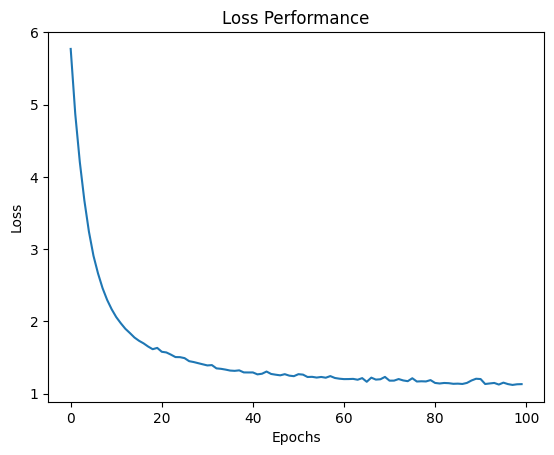

In [45]:
plot_model(history, "accuracy")
plot_model(history, "loss")

## Making Predictions with the Final Model

In [46]:
seed_text = "and if youll but listen ill make".lower()
next_words = 10

for i in range(10):
    
    # Tokenization and Sequencing
    seq_of_tokens = final_tokenizer.texts_to_sequences([seed_text])
    padded_seq_of_token = pad_sequences(seq_of_tokens, maxlen=maxlen - 1)
    
    # Making the Prediction for the Seed Text
    prediction = np.argmax(final_model.predict(padded_seq_of_token, verbose=0))
    out_word = word_idx_reverse[prediction - 1][0]
    
    # Updating the Seed Text to continue text generation
    seed_text += " " + out_word
    
print("AI Generated Text:\n", seed_text)
print("\nOriginal Text:\nand if youll but listen ill make your eyes glisten of the rows and the ructions of lanigans ball.")

AI Generated Text:
 and if youll but listen ill make ready linnets racking workin chamber wines hurley jailer dare pardon

Original Text:
and if youll but listen ill make your eyes glisten of the rows and the ructions of lanigans ball.


## Wrap Up 🙂

- If you made it till the end, I hope you the notebook interesting and fun.
- I had a lot of fun creating this one 🙃.
- Cheers!! for reading all the way ✌🏼